In [1]:
import numpy as np
import cv2
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dty

In [2]:
model = load_model('D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [155]:
def get_stmeter_no(imagepath):
    # Read the streetlight image
    image = cv2.imread(imagepath)
    
    # Convert the image to grayscale, and blur it to reduce noise
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
    edged = cv2.Canny(blurred, 30, 25)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="top-to-bottom")[0]
    
    # Initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
    chars = []

    # Loop over the contours
    for c in cnts:
        # Compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Filter out bounding boxes, ensuring they are neither too small nor too large
        #if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        if cv2.contourArea(c) > 25:
        # extract the character and threshold it to make the character appear as *white* (foreground) on a *black* background, 
        # then grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] 
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            
            # re-grab the image dimensions (now that its been resized) and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
        
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
        
            # prepare the padded image for classification via our handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
        
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
            
    # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)
    
    for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]
        if prob * 100 > 20:        
            # draw the prediction on the image
            print("{} - {:.2f}%".format(label, prob * 100))
            aspect_ratio = w / h
            print(np.round(aspect_ratio,2))
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    return image

L - 53.10%
0.09
C - 99.62%
0.81
8 - 91.30%
0.34
Z - 37.99%
5.68
9 - 90.41%
0.61
Z - 90.08%
0.98
I - 48.08%
0.06
F - 58.69%
4.89
L - 40.96%
0.13
7 - 99.92%
0.5
3 - 23.95%
0.48
Z - 39.04%
4.27
Q - 94.94%
0.79
Y - 30.10%
0.58
8 - 23.73%
1.0
M - 94.94%
1.6


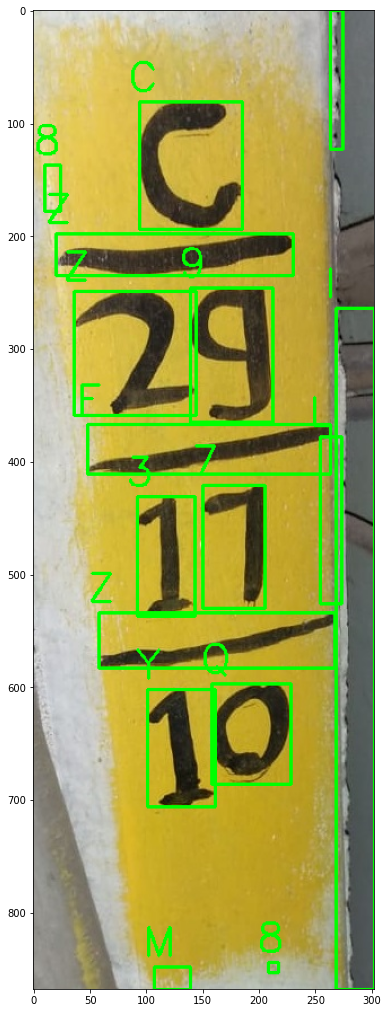

In [156]:
imagepath = 'D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\2_cropped.jpg'

meter_no = get_stmeter_no(imagepath)

plt.figure(figsize=(22,18))
img = cv2.cvtColor(meter_no, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Extracting Vertical Lines

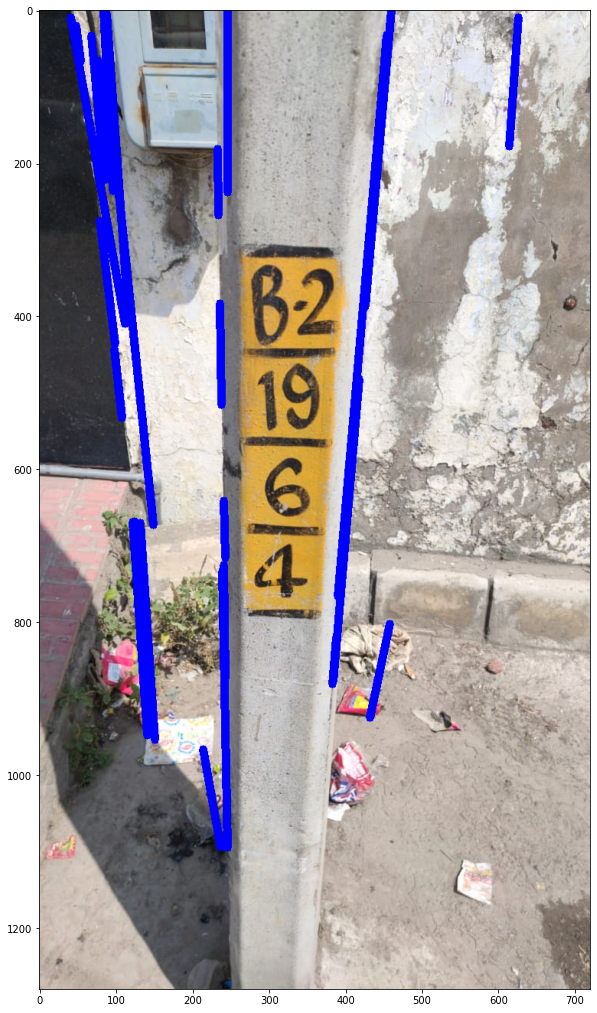

In [179]:
im = cv2.imread('D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\5.jpg')
    
# Convert the image to grayscale, and blur it to reduce noise
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
# Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
edged = cv2.Canny(blurred, 30, 150)

rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 200     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 30    # maximum gap in pixels between connectable line segments

# This returns an array of r and theta values 
lines = cv2.HoughLinesP(edged, rho, theta, threshold, np.array([]),min_line_length, max_line_gap) 
  
# The below for loop runs till r and theta values  
# are in the range of the 2d array 
for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(im,(x1,y1),(x2,y2),(255,0,0),10)
            
    
plt.figure(figsize=(22,18))
j = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(j)  

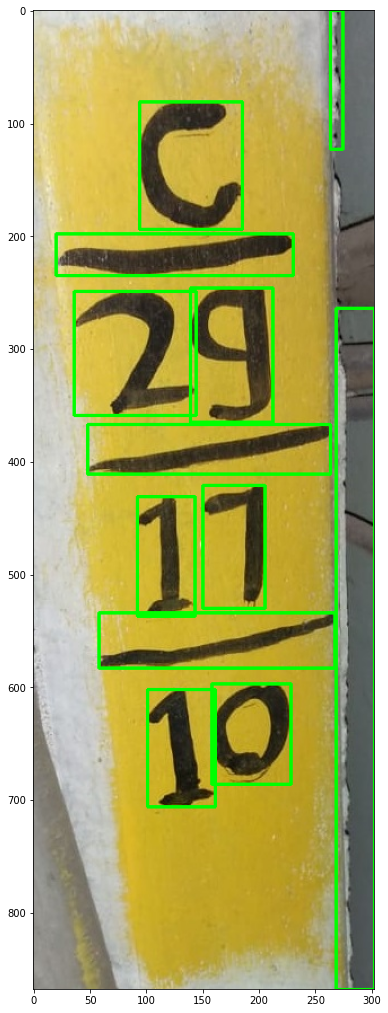

In [131]:
im = cv2.imread('D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\2_cropped.jpg')
    
# Convert the image to grayscale, and blur it to reduce noise
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
# Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0]

boxes = []
for c in cnts:
    if cv2.contourArea(c) > 25:
           
    # Compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
         
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        

plt.figure(figsize=(22,18))
i = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(i)    

In [132]:
boxes = []
for c in cnts:
    # Compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    boxes.append(x)
    boxes.append(y)
    boxes.append(x + w)
    boxes.append(y + h)
    
boxes = np.asarray(boxes)
boxes = np.reshape(boxes, (-1, 4))

In [112]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick]

In [75]:
def non_max_suppression_fast(boxes, probs=None, overlapThresh=0.3):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

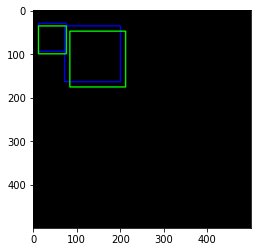

In [126]:
test = np.zeros((500, 500), dtype = "uint8")
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

#b = np.array([(12, 84, 140, 212), (24, 84, 152, 212), (36, 84, 164, 212), (12, 96, 140, 224), (24, 96, 152, 224),
#    (24, 108, 152, 236)])

b = np.array([(12, 30, 76, 94), (12, 36, 76, 100), (72, 36, 200, 164), (84, 48, 212, 176)])

for (startX, startY, endX, endY) in b:
        cv2.rectangle(test, (startX, startY), (endX, endY), (0, 0, 255), 2)
        
# perform non-maximum suppression on the bounding boxes
pick = non_max_suppression_slow(b, 0.3)

# loop over the picked bounding boxes and draw them
for (startX, startY, endX, endY) in pick:
        cv2.rectangle(test, (startX, startY), (endX, endY), (0, 255, 0), 2)
        
plt.imshow(test)

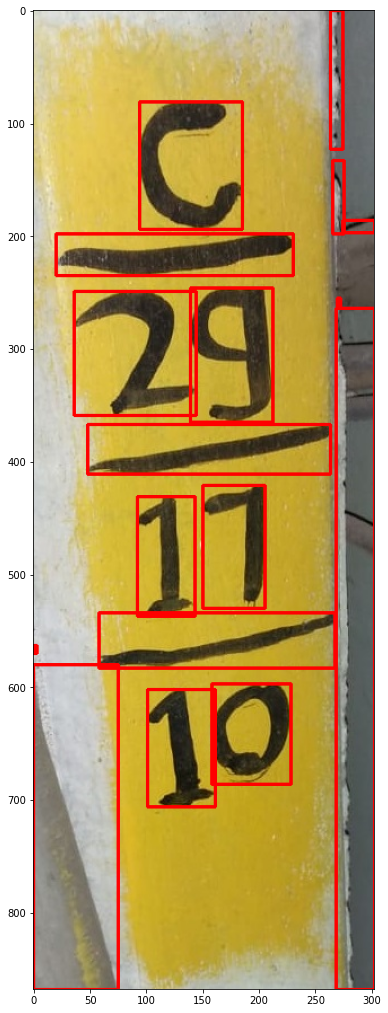

In [133]:
nms = non_max_suppression_slow(boxes, 0.3)
for (startX, startY, endX, endY) in nms:
        cv2.rectangle(i, (startX, startY), (endX, endY), (255, 0, 0), 2)

plt.figure(figsize=(22,18))
plt.imshow(i)